# Demonstrate Bayesian Optimization on THz TDS Fitting

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from Matrix_methods.Simulate import simulate_reference, simulate_parallel
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor

In [2]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

[((3.46-0.01j), 0.001), ((2.5-0.015j), 0.0002)]


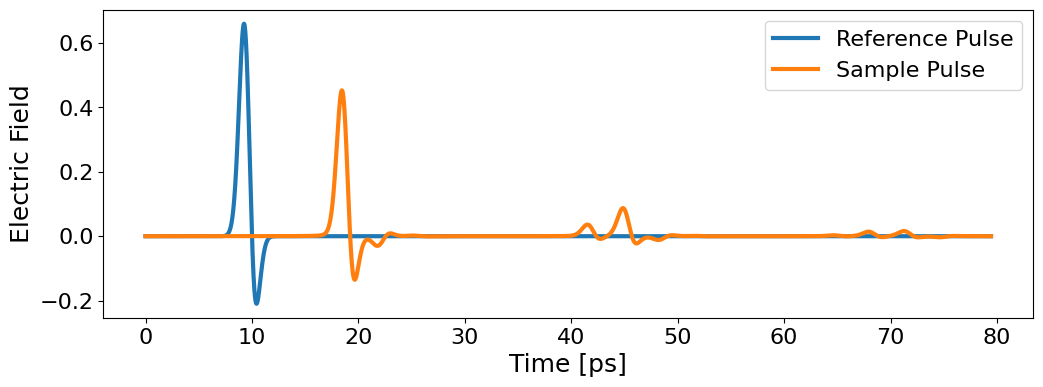

In [3]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n1, k1, d1 = 3.46, -0.01, 1e-3
n2, k2, d2= 2.5, -0.015, 0.2e-3

# Experimental material parameters (ground truth)
material_params_exp = [(n1+1j*k1, d1), (n2+1j*k2, d2)]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
_, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]

print(material_params_exp)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

## Fit just n's and k's with Bayesian Optimization

### Bayesian optimization to find starting parameters

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (2.67, 3.67)
Layer 1 - k ∈ (-0.025, -0.004999999999999999)
Layer 1 - D ∈ (0.0006000000000000001, 0.0012)
Layer 2 - n ∈ (1.7000000000000002, 2.7)
Layer 2 - k ∈ (-0.027000000000000003, -0.007000000000000001)
Layer 2 - D ∈ (0.00010000000000000005, 0.0007)
[((3.33143057528743-0.015104570087802437j), 0.0011110393812933995), ((2.7-0.017734432581690406j), 0.00010000000000000005)]


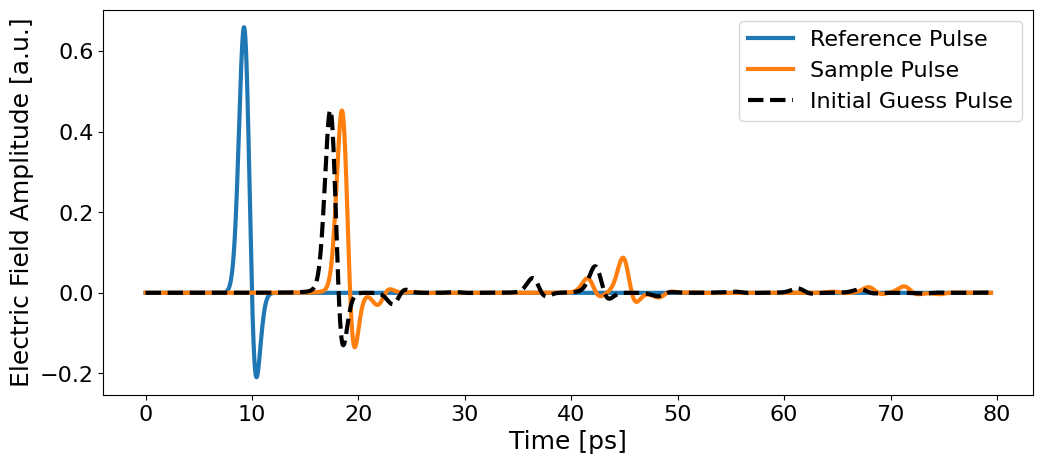

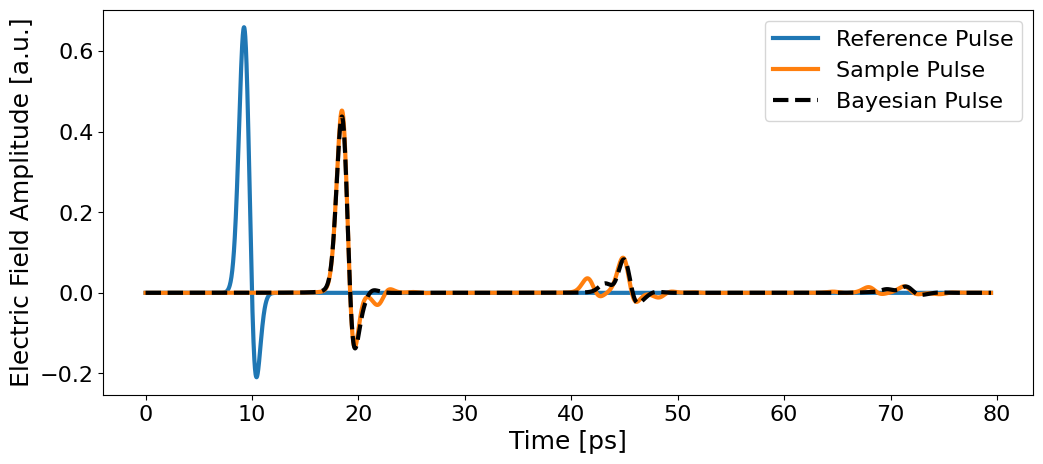

In [4]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.2e-3

optimize_mask = [
    (True, True, True),  
    (True, True, True),    
]

optimization_bounds = [0.5, 0.01, 0.3e-3]

layers_init = [(3.17-0.015*1j, 0.9e-3), (2.2-1j*0.017, 0.4e-3)]

initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat, 0)[1][:L]

BLE_NK = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimize_mask, optimization_bounds=optimization_bounds)
bayesian_params = BLE_NK.bayesian_optimization(n_calls=200)
print(bayesian_params)

_, bayesian_pulse = simulate_parallel(reference_pulse, bayesian_params, deltat, noise_level=0)
bayesian_pulse = bayesian_pulse[:L]

plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, initial_pulse.detach().cpu().numpy(), label='Initial Guess Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()



plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, bayesian_pulse.detach().cpu().numpy(), label='Bayesian Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

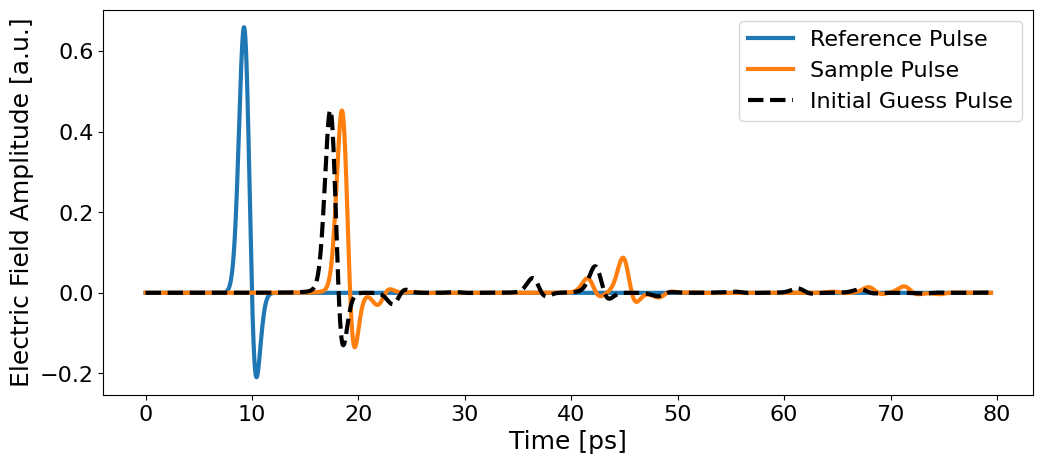

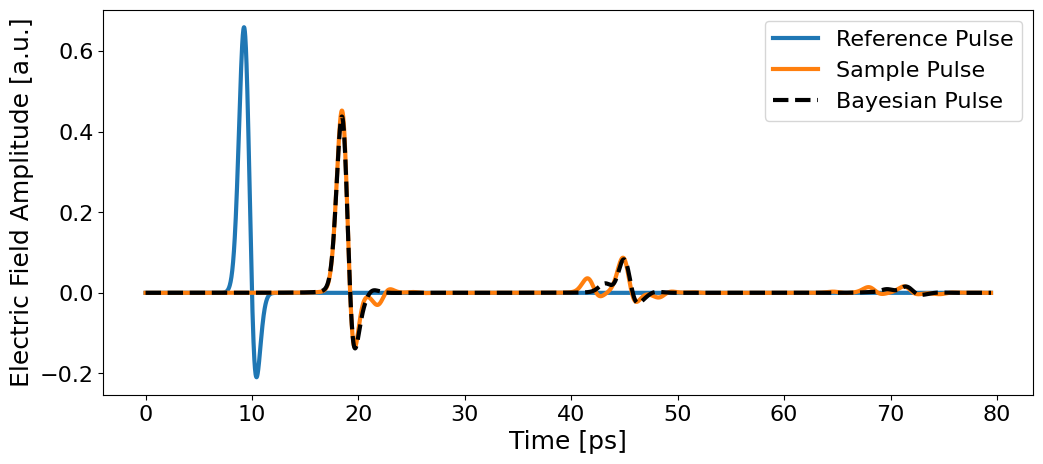

In [5]:
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, initial_pulse.detach().cpu().numpy(), label='Initial Guess Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()



plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, bayesian_pulse.detach().cpu().numpy(), label='Bayesian Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

In [6]:
init_errors = compare_material_stacks(layers_init, material_params_exp)
for e in init_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.29 (8.38%), n_imag_abs_err=0.005 (50.00%), d_abs_err=0.0001 (10.00%)
Layer 2: n_real_abs_err=0.3 (12.00%), n_imag_abs_err=0.002 (13.33%), d_abs_err=0.0002 (100.00%)


In [7]:
bayes_errors = compare_material_stacks(bayesian_params, material_params_exp)
for e in bayes_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.128569 (3.72%), n_imag_abs_err=0.00510457 (51.05%), d_abs_err=0.000111039 (11.10%)
Layer 2: n_real_abs_err=0.2 (8.00%), n_imag_abs_err=0.00273443 (18.23%), d_abs_err=0.0001 (50.00%)


### Fine-tune with Adam Gradient Decent

Optimizing n and k with initial conditions [((3.17-0.015j), 0.0009), ((2.2-0.017j), 0.0004)]
Fine-tuning 6 parameters for 2000 iterations.
Iteration 99, Loss: 6.477864e-03, Layer 0: n=3.3355, k=-0.01111, D=1103.67 µm | Layer 1: n=2.7886, k=-0.03728, D=101.15 µm
Iteration 199, Loss: 6.105030e-03, Layer 0: n=3.3383, k=-0.00775, D=1091.99 µm | Layer 1: n=2.8762, k=-0.06165, D=109.51 µm
Iteration 299, Loss: 5.171552e-03, Layer 0: n=3.3496, k=0.00088, D=1066.42 µm | Layer 1: n=2.9478, k=-0.11531, D=130.59 µm
Iteration 399, Loss: 3.638291e-03, Layer 0: n=3.3738, k=0.01571, D=1036.88 µm | Layer 1: n=2.9110, k=-0.18865, D=157.16 µm
Iteration 499, Loss: 2.173911e-03, Layer 0: n=3.3986, k=-0.00159, D=1021.02 µm | Layer 1: n=2.7579, k=-0.06390, D=177.24 µm
Iteration 599, Loss: 9.457655e-04, Layer 0: n=3.4303, k=-0.00705, D=1009.43 µm | Layer 1: n=2.6095, k=-0.03005, D=190.42 µm
Iteration 699, Loss: 2.408413e-04, Layer 0: n=3.4523, k=-0.00944, D=1002.42 µm | Layer 1: n=2.5256, k=-0.01848, D=197.69

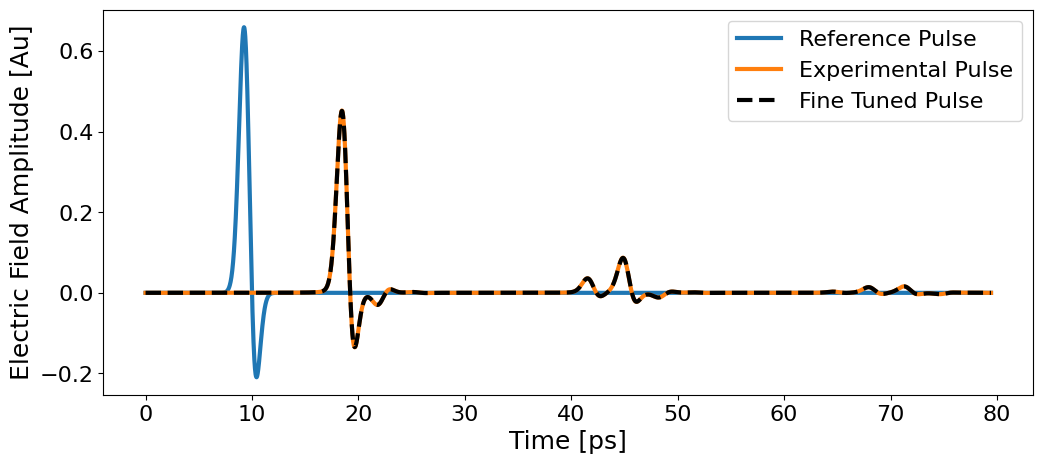

In [8]:
alpha = 1
LE_nk = LayeredExtractor(reference_pulse, experimental_pulse, deltat, bayesian_params, lr=0.001, optimize_mask=optimize_mask)
print(f'Optimizing n and k with initial conditions {layers_init}')
optim_params = LE_nk.optimize(num_iterations=2000, updates=100, alpha=alpha)



_, optimal_pulse_nk = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse_nk = optimal_pulse_nk[:L]

print(optim_params)
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse', linewidth='3')
plt.plot(t_axis*1e12, optimal_pulse_nk.detach().cpu().numpy(), label='Fine Tuned Pulse', linestyle='--', color='k', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [Au]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

In [9]:
adam_errors = compare_material_stacks(optim_params, material_params_exp)
for e in adam_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.000138083 (0.00%), n_imag_abs_err=0.000255961 (2.56%), d_abs_err=1.35322e-07 (0.01%)
Layer 2: n_real_abs_err=0.000131845 (0.01%), n_imag_abs_err=0.00025281 (1.69%), d_abs_err=2.75417e-08 (0.01%)


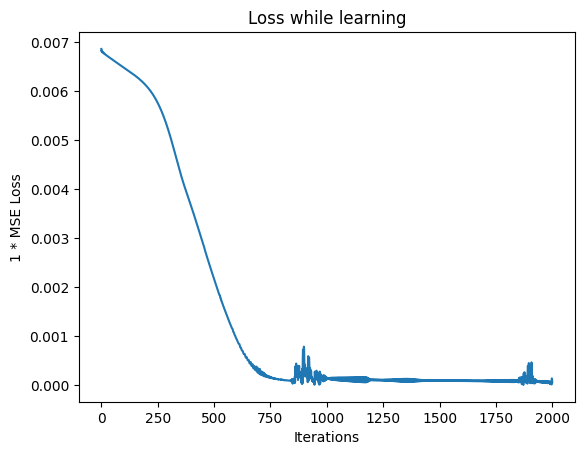

In [10]:
plt.plot(LE_nk.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'{alpha} * MSE Loss')
plt.title('Loss while learning')

plt.show()

### Plot residuals

In [11]:
n_res = np.zeros(len(optim_params))
k_res = np.zeros(len(optim_params))
i=0
for layer in optim_params:
    n_res[i] = np.real(layer[0]) - np.real(material_params_exp[i][0])
    k_res[i] = np.imag(layer[0]) - np.imag(material_params_exp[i][0])
    print(f'n residual for layer {i}: {n_res[i]}')
    print(f'k residual for layer {i}: {k_res[i]}')
    i+=1

n residual for layer 0: 0.00013808250427249646
k residual for layer 0: -0.00025596074759960154
n residual for layer 1: 0.00013184547424316406
k residual for layer 1: -0.0002528099715709692


## Extract thicknesses of multiple layers

### Bayesian Optimization to find initial values

In [12]:
## Experimental params:
# n1, k1, d1 = 3.46, 0.01, 1e-3
# n2, k2, d2= 2.5, 0.015, 0.5e-3

optimize_mask = [
    (False, False, True),  
    (False, False, True),    
]

# Initial guess must be within 150um of the correct answer.
layers_D_init = [(n1+1j*k1, 0.9e-3), (n2+1j*k2, 0.4e-3)]
alpha = 1

initial_pulse = simulate_parallel(reference_pulse, layers_D_init, deltat, 0)[1][:L]

BLE_D = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_D_init, optimize_mask=optimize_mask)

print(f'Optimizing n and k with initial conditions {layers_D_init}')
Bayesian_params_D = BLE_D.bayesian_optimization(n_calls=30)

_, Bayesian_pulse_D = simulate_parallel(reference_pulse, Bayesian_params_D, deltat, noise_level=0)
Bayesian_pulse_D = Bayesian_pulse_D[:L]

print(Bayesian_params_D)

Optimizing n and k with initial conditions [((3.46-0.01j), 0.0009), ((2.5-0.015j), 0.0004)]
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - D ∈ (0.00075, 0.00105)
Layer 2 - D ∈ (0.00025, 0.00055)
[((3.46-0.01j), 0.000972868949061441), ((2.5-0.015j), 0.00025)]


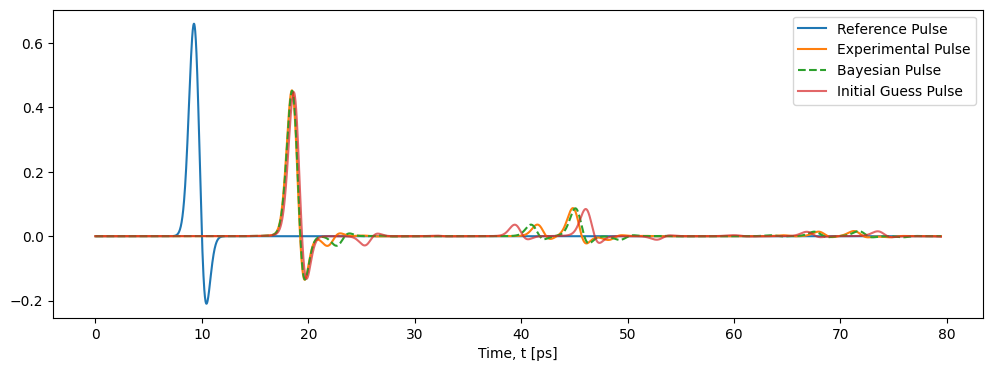

In [13]:
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis*1e12, Bayesian_pulse_D.detach().cpu().numpy(), label='Bayesian Pulse', linestyle='--')
plt.plot(t_axis*1e12, initial_pulse.detach().cpu().numpy(), label='Initial Guess Pulse', alpha=0.7)

plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

### Fine-tune on Adam

Optimizing n and k with initial conditions [((3.46-0.01j), 0.0009), ((2.5-0.015j), 0.0004)]
Fine-tuning 2 parameters for 150 iterations.
Iteration 14, Loss: 5.991035e-03, Layer 0: n=3.4600, k=-0.01000, D=970.35 µm | Layer 1: n=2.5000, k=-0.01500, D=247.93 µm
Iteration 29, Loss: 5.810710e-03, Layer 0: n=3.4600, k=-0.01000, D=970.93 µm | Layer 1: n=2.5000, k=-0.01500, D=245.58 µm
Iteration 44, Loss: 5.537797e-03, Layer 0: n=3.4600, k=-0.01000, D=973.07 µm | Layer 1: n=2.5000, k=-0.01500, D=243.06 µm
Iteration 59, Loss: 5.246433e-03, Layer 0: n=3.4600, k=-0.01000, D=975.02 µm | Layer 1: n=2.5000, k=-0.01500, D=240.19 µm
Iteration 74, Loss: 4.917294e-03, Layer 0: n=3.4600, k=-0.01000, D=976.95 µm | Layer 1: n=2.5000, k=-0.01500, D=237.09 µm
Iteration 89, Loss: 4.555726e-03, Layer 0: n=3.4600, k=-0.01000, D=978.97 µm | Layer 1: n=2.5000, k=-0.01500, D=233.85 µm
Iteration 104, Loss: 4.165227e-03, Layer 0: n=3.4600, k=-0.01000, D=981.05 µm | Layer 1: n=2.5000, k=-0.01500, D=230.50 µm
Iteratio

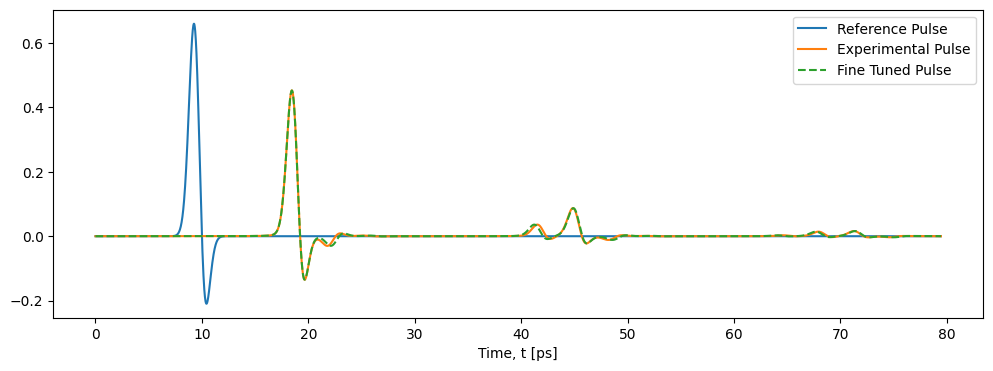

In [14]:
# Initial guess must be within 150um of the correct answer.
Bayesian_init_D = Bayesian_params_D

LE_D = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_init_D, lr=0.001, optimize_mask=optimize_mask)
print(f'Optimizing n and k with initial conditions {layers_D_init}')
optim_params_D = LE_D.optimize(num_iterations=150, updates=15)



_, optim_pulse_D = simulate_parallel(reference_pulse, optim_params_D, deltat, noise_level=0)
optim_pulse_D = optim_pulse_D[:L]

print(optim_params_D)
plt.figure(figsize=(12,4))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Experimental Pulse')
plt.plot(t_axis*1e12, optim_pulse_D.detach().cpu().numpy(), label='Fine Tuned Pulse', linestyle='--')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

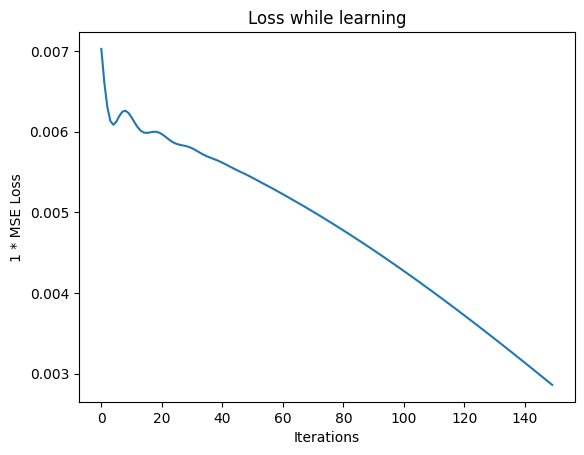

In [15]:
plt.plot(LE_D.loss_history)
plt.xlabel('Iterations')
plt.ylabel(f'{alpha} * MSE Loss')
plt.title('Loss while learning')

plt.show()

### Calculate residuals

In [16]:
D_res = np.zeros(len(optim_params))
i=0
for layer in optim_params_D:
    D_res[i] = layer[1] - material_params_exp[i][1]
    print(f'Residual for layer {i}: {D_res[i]}')
    i+=1

Residual for layer 0: -1.248374953866007e-05
Residual for layer 1: 2.0162954065017393e-05
